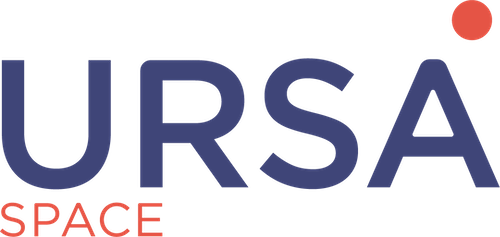

# Global Oil Storage API

Ursa's Global Oil Storage RESTful API helps to retrieve insights from the global oil inventory collection. On a weekly cadence, Ursa measures the oil storage capacities in different global locations and outputs the data into a database for easy consumption.

For more information, please visit our documentation at https://info.ursaspace.com/global-oil-storage.

## Authentication/Login Endpoint

Ursa Space endpoints use bearer tokens to authenticated incoming requests. Bearer tokens are retrieved by calling the `https://platform.ursaspace.com/api/pas/login` endpoint with your Ursa username and password. The tokens then are passed in request headers in all subsequent endpoint calls.

For more information, see https://info.ursaspace.com/oil-storage-authentication.

In [ ]:
import os
import requests
import json

# API consts
API_DOMAIN = 'https://platform.ursaspace.com'
ENDPOINT_LOGIN = '/api/pas/login'
ENDPOINT_DETAILED = '/api/data/detailed/find'
ENDPOINT_AGGREGATE = '/api/data/aggregate/find'

# Read username/password from environment variables
# For new users looking to sign up, please contact info@ursaspace.com
URSA_USERNAME = os.getenv('URSA_USERNAME')
URSA_PASSWORD = os.getenv('URSA_PASSWORD')

# Login to retrieve JWT
auth_form = {'grant_type': 'password',
             'username': URSA_USERNAME,
             'password': URSA_PASSWORD}

response = requests.post(f'{API_DOMAIN}{ENDPOINT_LOGIN}', data=auth_form)
if response.status_code != 200:
    raise Exception(f"Login failed ({response.status_code}, {response.text})")
    
# JWTs are passed as auth bearer tokens to API requests
jwt = response.json()['access_token']
auth_header = {
    'Authorization': f'Bearer {jwt}'
}

print(auth_header)

## Detailed Endpoint

The `detailed` endpoint is responsible for returning tank-by-tank results that are organized by user-defined groupings. When the database is updated with the latest results from the global inventory, this endpoint reflects those changes.

Possible groupings include, but aren't limited to, location (e.g., region, country) and oil company metadata (e.g., company name, terminal name).

For more information, please visit https://info.ursaspace.com/oil-storage-detailed-endpoint.

### Detailed endpoint request format

The basic form for the detailed request is: 

```
https://platform.ursaspace.com/api/data/detailed/find?qry_<FieldName>=<Value>&qry_<TimeField>_start=<timestamp>&qry_<TimeField>_end=<timestamp>
```

Queryable fields take the form `qry_<FieldName>=<Value>`. Multiple queryable fields may be utilized in a single request as query parameters separated by an ampersand in the request URL. See the data dictionary at https://info.ursaspace.com/oil-storage-fields-value-definitions for a full list of queryable fields.

Time range field options include `ReportTime`, `PublishTime` and `ResultTime`. Only one time range field can be queried on at a time, and the start date must be before the end date. Timestamps should take the form `YYYY-MM-DDThh:mm:ssZ` based on ISO 8601 standard. No quotes, single or double, are used around any values.

Fields returned in the response are defined at https://info.ursaspace.com/osp-data-dictionary.

### Detailed endpoint example queries

In [ ]:
# Query for all tank measurements in Argentina with 2023 April report dates

# You can construct the URL with query parameters manually, but many programming language libraries support adding the parameters as key-value pairs.
# The library then generates the URL with the appropriate ? and & separaters.

# For example, below will send a GET request with the appropriate authentication header to the following URL:
# https://platform.ursaspace.com/api/data/detailed/find?qry_Country=Argentina&qry_ReportTime_start=2023-04-01T14:00:00.000Z&qry_ReportTime_end=2023-04-30T14:00:00.000Z
query_params = {
    'qry_Country': 'Argentina',
    'qry_ReportTime_start': '2023-04-01T00:00:00.000Z',
    'qry_ReportTime_end': '2023-05-01T00:00:00.000Z',
}
response = requests.get(f'{API_DOMAIN}{ENDPOINT_DETAILED}', headers=auth_header, params=query_params)
print(f"URL: {response.url}")
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))

In [ ]:
# Query for China tank measurements published between May 22, 2023 and May 23, 2023
query_params = {
    'qry_Country': 'China',
    'qry_PublishTime_start': '2023-05-22T00:00:00.000Z',
    'qry_PublishTime_end': '2023-05-23T00:00:00.000Z',
}
response = requests.get(f'{API_DOMAIN}{ENDPOINT_DETAILED}', headers=auth_header, params=query_params)
print(f"URL: {response.url}")
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))

In [ ]:
# Query for refinery tanks in Nigeria from Jan 1, 2023 to Feb 1, 2023
query_params = {
    'qry_Country': 'Nigeria',
    'qry_StorageType': 'Refinery',
    'qry_PublishTime_start': '2023-01-01T00:00:00.000Z',
    'qry_PublishTime_end': '2023-02-01T00:00:00.000Z',
}
response = requests.get(f'{API_DOMAIN}{ENDPOINT_DETAILED}', headers=auth_header, params=query_params)
print(f"URL: {response.url}")
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))

## Aggregate Endpoint

The `aggregate` endpoint is responsible for returning aggregations (i.e., the sums or averages) based on user-defined groupings. Unlike the `detailed` endpoint, the aggregates are updated on a weekly basis (Thursdays at 14:00 UTC).

Possible groupings include, but aren't limited to, report metadata (e.g., report publish date) and temporal cadences (e.g., weekly, monthly).

For additional information, please visit https://info.ursaspace.com/oil-storage-aggregate-endpoint.

### Aggregate endpoint request format

The basic form for the aggregate request is: 
```
https://platform.ursaspace.com/api/data/aggregate/find?qry_<FieldName>=<Value>&qry_<TimeField>_start=<timestamp>&qry_<TimeField>_end=<timestamp>&grp_<TimeWindow>=ReportTime&grp_ValueOf=<GroupByField>&agg_<AggregationType>
```

Possible `<TimeWindow>`, `<GroupByField>`, and `<AggregationType>` values can be found at https://info.ursaspace.com/oil-storage-fields-value-definitions.

Queryable fields and time fields take the same form as with the `detailed` endpoint above.

Fields returned in the response are defined at https://info.ursaspace.com/osp-data-dictionary.

### Aggregate endpoint request examples

In [ ]:
# Query for tank sums in all LocationNames within China for the month of April, 2023
# This is also a good way to generate all valid LocationNames within a country
query_params = {
    'qry_Country': 'China',
    'grp_ValueOf': 'LocationName',
    'qry_ReportTime_start': '2023-04-01T00:00:00.000Z',
    'qry_ReportTime_end': '2023-05-01T00:00:00.000Z',
    'agg_Sum': '',
}
response = requests.get(f'{API_DOMAIN}{ENDPOINT_AGGREGATE}', headers=auth_header, params=query_params)
print(f"URL: {response.url}")
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))

In [ ]:
# Query tank averages in each country in the first week of May, 2023
query_params = {
    'grp_ValueOf': 'Country',
    'qry_ReportTime_start': '2023-05-01T00:00:00.000Z',
    'qry_ReportTime_end': '2023-05-07T00:00:00.000Z',
    'agg_Avg': '',
}
response = requests.get(f'{API_DOMAIN}{ENDPOINT_AGGREGATE}', headers=auth_header, params=query_params)
print(f"URL: {response.url}")
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))

In [ ]:
# Query tank sums of Shell in each country in the first week of May, 2023
query_params = {
    'qry_Company': 'Shell',
    'grp_ValueOf': 'Country',
    'qry_ReportTime_start': '2023-05-01T00:00:00.000Z',
    'qry_ReportTime_end': '2023-05-07T00:00:00.000Z',
    'agg_Sum': '',
}
response = requests.get(f'{API_DOMAIN}{ENDPOINT_AGGREGATE}', headers=auth_header, params=query_params)
print(f"URL: {response.url}")
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))

In [ ]:
# Using different `qry_<field>` fields will treat each field as an AND in the query, for instance
# qry_Company=Shell and qry_Country=United States will search for tanks from both Shell AND the United States

# Query tank sums of Shell locations in the United States in the first week of May, 2023
query_params = {
    'qry_Company': 'Shell',
    'qry_Country': 'United States',
    'grp_ValueOf': 'LocationName',
    'qry_ReportTime_start': '2023-05-01T00:00:00.000Z',
    'qry_ReportTime_end': '2023-05-07T00:00:00.000Z',
    'agg_Sum': '',
}
response = requests.get(f'{API_DOMAIN}{ENDPOINT_AGGREGATE}', headers=auth_header, params=query_params)
print(f"URL: {response.url}")
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))

In [ ]:
# Using the same `qry_<field>` field will treat each field as an OR between each other in the query, for instance
# qry_Country=United States and qry_Country=Brazil will search for tanks in either the United States OR Brazil

# NOTE: Python dictionaries do not allow duplicate keys, so we have to structure the `query_params` a little
# differently. Different languages and libraries may differ in how they handle duplicate keys.

# Query tank sums of Shell in the United States or Brazil in the first week of May, 2023
query_params = {
    'qry_Company': 'Shell',
    'qry_Country': ('United States', 'Brazil'),
    'grp_ValueOf': 'Country',
    'qry_ReportTime_start': '2023-05-01T00:00:00.000Z',
    'qry_ReportTime_end': '2023-05-07T00:00:00.000Z',
    'agg_Sum': '',
}
response = requests.get(f'{API_DOMAIN}{ENDPOINT_AGGREGATE}', headers=auth_header, params=query_params)
print(f"URL: {response.url}")
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))

In [ ]:
# Using multiple `qry_<field>` fields with the same and different values, the API will look for multiple combinations between the fields.
# For instance, qry_Country=United States, qry_Country=China, qry_LocationName=Cushing, and qry_LocationName=Dalian will search for tanks 
# in (Cushing, US), (Dalian, US), (Cushing, China) or (Dalian, China). Because we know there are no tanks in Dalian, US or Cushing, China,
# no results will be returned for those locations.

# NOTE: Python dictionaries do not allow duplicate keys, so we have to structure the `query_params` a little
# differently. Different languages and libraries may differ in how they handle duplicate keys.

# Query tank sums in Cushing, US and Dalian, China in the first week of May, 2023
query_params = {
    'qry_Country': ('United States', 'China'),
    'qry_LocationName': ('Cushing', 'Dalian'),
    'grp_ValueOf': 'LocationName',
    'qry_ReportTime_start': '2023-05-01T00:00:00.000Z',
    'qry_ReportTime_end': '2023-05-07T00:00:00.000Z',
    'agg_Sum': '',
}
response = requests.get(f'{API_DOMAIN}{ENDPOINT_AGGREGATE}', headers=auth_header, params=query_params)
print(f"URL: {response.url}")
json_resp = json.loads(response.text)
print(json.dumps(json_resp, indent=2))